In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [2]:
# Membaca dataset dengan pengecekan encoding
df = pd.read_csv('data/origin-data/google-play-rev-gen-2.csv', encoding='utf-8')

# Memeriksa beberapa baris pertama
df.head(10)

,id,title,avatar,rating,snippet,likes,date,iso_date,response
0,e5384431-56f9-43fa-a32a-53296afc7f66,Seraphim,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"While I've reviewed this before, I decided to ...",88,"October 09, 2024",2024-10-09T00:08:20Z,NaN
1,6a73081f-3490-47ba-89fa-83744cb20940,TWOSTORE !,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,Very fun but I wish there was more fighting in...,35,"October 12, 2024",2024-10-12T06:39:01Z,NaN
2,3a3d4c90-0b6e-45dc-b1e6-014659055bbf,A G,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"Fun game, I enjoy the story. There is tons to ...",11,"October 30, 2024",2024-10-30T18:01:37Z,NaN
3,99015538-1d26-4bd9-a02f-37bc2a361d1a,Astra,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,This game is phenomenal. The art style and sce...,77,"October 18, 2024",2024-10-18T19:11:12Z,NaN
4,541b3b4d-97f6-42e0-9c68-059a63e1e67f,Angela Williams,https://play-lh.googleusercontent.com/a-/ALV-U...,2.0,"I love this game. However, it is incredibly la...",14,"October 14, 2024",2024-10-14T03:04:43Z,NaN
5,ad484b6a-1b9c-42ab-9cee-9df6e28f12d4,Valerie,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,I used to be obsessed with this game but I hav...,99,"October 13, 2024",2024-10-13T14:02:08Z,NaN
6,fb25cdf6-40d8-44e8-b1b9-d439ebd88565,Daniel “Chotara” Ricciardi,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,Highly recommend. I have been playing the game...,65,"October 18, 2024",2024-10-18T15:20:11Z,NaN
7,36e821d3-9441-4eaa-94a7-9c7b9b7463b5,Amy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,Hello! I absolutely love this game! It has inc...,29,"October 29, 2024",2024-10-29T00:27:08Z,NaN
8,4b1e6dcb-d251-450e-9be6-358b4bb8e9d6,Feitan Desy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,I've been playing this game since January 16th...,64,"October 08, 2024",2024-10-08T23:13:09Z,NaN
9,27525772-1c0a-40e4-8321-4c5f0a0f7c64,Olivia Staringer,https://play-lh.googleusercontent.com/a-/ALV-U...,1.0,"Uninteresting characters, uninteresting dialog...",14,"November 11, 2024",2024-11-11T22:58:07Z,NaN


In [3]:
# import pandas as pd
import os

# Reading the dataset with encoding check
df = pd.read_csv('data/origin-data/google-play-rev-gen-2.csv', encoding='utf-8')

# Define the function to classify ratings
def classify_rating(rating):
    if rating in [3, 4, 5]:
        return 'positive'
    elif rating in [1, 2]:
        return 'negative'
    # elif rating == 3:
    #     return 'neutral'
    return 'unknown'

# Apply the classification function to create the 'rating_label' column
df['rating_label'] = df['rating'].apply(classify_rating)

# Create the 'new-changedData' directory if it doesn't exist
output_directory = 'data/new-changedData'
os.makedirs(output_directory, exist_ok=True)

# Define the output file path
output_file_path = os.path.join(output_directory, 'google-play-rev-gen-2-with-rating-label.csv')

# Save the updated DataFrame to the new CSV file inside the directory
df.to_csv(output_file_path, index=False)

# Print the first few rows to check the result
print(df[['rating', 'rating_label']].head(10))

# Confirm the file has been saved
print(f"File saved to: {output_file_path}")


   rating rating_label
0     3.0     positive
1     3.0     positive
2     3.0     positive
3     5.0     positive
4     2.0     negative
5     3.0     positive
6     5.0     positive
7     4.0     positive
8     4.0     positive
9     1.0     negative
File saved to: data/new-changedData/google-play-rev-gen-2-with-rating-label.csv


In [4]:
# Calculate the total number of data points
total_data_count = len(df)

# Calculate the number of data per 'rating_label'
rating_label_counts = df['rating_label'].value_counts()

# Display the total number of data points and the counts per 'rating_label'
print(f"Total data: {total_data_count}")
print("\nAmount of rating data rating_label:")
print(rating_label_counts)

# Calculate the number of data based on the original rating values
rating_counts = df['rating'].value_counts()

# Display the counts based on rating
print("\ntotal data based on rating:")
print(rating_counts)

Total data: 199

Amount of rating data rating_label:
rating_label
positive    155
negative     44
Name: count, dtype: int64

total data based on rating:
rating
5.0    80
4.0    42
3.0    33
1.0    23
2.0    21
Name: count, dtype: int64


In [5]:
import pandas as pd
import spacy
import re

# Load spaCy model (make sure to download the model first using: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

# Function to clean text using spaCy (lemmatization, remove stop words, punctuation, numbers, emojis, etc.)
def clean_text_spacy(text):
    # Normalize text: lowercase, remove special characters, emojis, and lemmatize
    text = text.lower()  # Convert to lowercase
    
    # Remove emojis using a regex pattern
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F700-\U0001F77F"  # Alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric shapes
        "\U0001F800-\U0001F8FF"  # Supplemental arrows
        "\U0001F900-\U0001F9FF"  # Supplemental symbols
        "\U0001FA00-\U0001FA6F"  # Chess symbols
        "\U0001FA70-\U0001FAFF"  # Symbols & pictographs extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub(r'', text)  # Remove emojis
    
    # Remove other unwanted characters (symbols, punctuation, numbers)
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    
    # Process the cleaned text with spaCy
    doc = nlp(text)
    
    # Remove stop words, punctuation, and keep only lemmatized tokens
    tokens = [
        token.lemma_ 
        for token in doc 
        if not token.is_stop and token.is_alpha
    ]
    return ' '.join(tokens)

# Load the dataset
df = pd.read_csv('data/new-changedData/google-play-rev-gen-2-with-rating-label.csv', encoding='utf-8')

# Remove duplicate reviews based on the 'snippet' column
df = df.drop_duplicates(subset='snippet')

# Clean the 'snippet' column and add a new 'cleaned_snippet' column
df['cleaned_snippet'] = df['snippet'].fillna('').apply(clean_text_spacy)

# Remove the original 'snippet' column and other unnecessary columns
df = df.drop(columns=['snippet', 'id', 'title', 'avatar', 'date', 'iso_date'])

# Display the first few rows to check the cleaned snippets
print("Cleaned snippets:")
print(df[['cleaned_snippet']].head(10))

# Save the cleaned data to a new CSV file
output_file = 'data/new-changedData/google-play-rev-gen-2-with-rating-label-clean-text.csv'
df.to_csv(output_file, index=False)

# Confirm the file has been saved
print(f"Cleaned data saved to: {output_file}")

Cleaned snippets:
                                     cleaned_snippet
0  ve review decide edit response current opinion...
1  fun wish fighting quest bunch talk run come qu...
2  fun game enjoy story ton ton content clear bor...
3  game phenomenal art style scenery stunning yes...
4  love game incredibly laggy point unplayable gr...
5  obsess game not play month boring repetitive g...
6  highly recommend play game year impressed mech...
7  hello absolutely love game incredible graphic ...
8  ve play game january th real complaint style n...
9  unintereste character unintereste dialog story...
Cleaned data saved to: data/new-changedData/google-play-rev-gen-2-with-rating-label-clean-text.csv


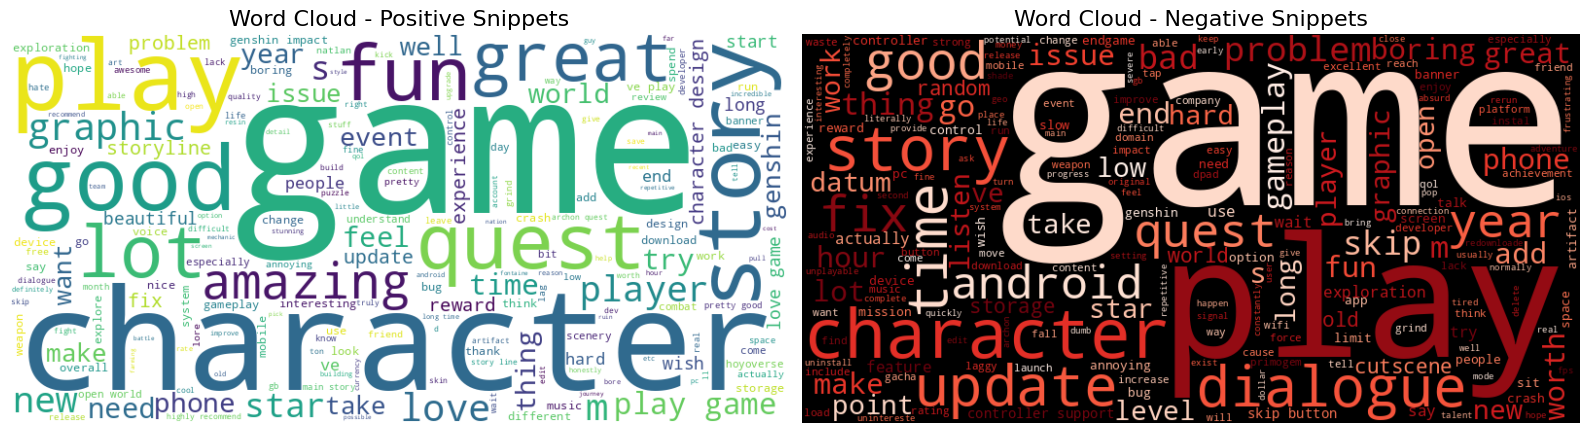

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the dataset
df = pd.read_csv('data/new-changedData/google-play-rev-gen-2-with-rating-label-clean-text.csv', encoding='utf-8')

# Filter positive and negative snippets
positive_snippets = df[df['rating_label'] == 'positive']['cleaned_snippet']
negative_snippets = df[df['rating_label'] == 'negative']['cleaned_snippet']

# Combine all positive and negative snippets into single strings
positive_text = " ".join(positive_snippets.dropna())
negative_text = " ".join(negative_snippets.dropna())

# Generate word clouds for positive and negative snippets
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Create a subplot for word clouds
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[0].set_title('Word Cloud - Positive Snippets', fontsize=16)
ax[0].axis('off')

ax[1].imshow(wordcloud_negative, interpolation='bilinear')
ax[1].set_title('Word Cloud - Negative Snippets', fontsize=16)
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
df = pd.read_csv('data/new-changedData/google-play-rev-gen-2-with-rating-label-clean-text.csv', encoding='utf-8')

# Extract the feature matrix (X) and target variable (y)
X = df['cleaned_snippet']  # Use the cleaned snippets as features
y = df['rating_label']  # Target variable is the 'rating_label'

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert text data to numerical using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)

# Check class distribution before ADASYN
print("Class distribution before ADASYN:", Counter(y_train))

# Initialize ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=5)

# Apply ADASYN to the training data
try:
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_vectorized, y_train)
except ValueError as e:
    print(f"Error during ADASYN resampling: {e}")
    exit()

# Check class distribution after ADASYN
print("Class distribution after ADASYN:", Counter(y_train_adasyn))

# Display the shape of the new oversampled training set
print(f"Shape of X_train_adasyn: {X_train_adasyn.shape}")
print(f"Shape of y_train_adasyn: {y_train_adasyn.shape}")

Class distribution before ADASYN: Counter({'positive': 124, 'negative': 35})
Class distribution after ADASYN: Counter({'positive': 124, 'negative': 123})
Shape of X_train_adasyn: (247, 1293)
Shape of y_train_adasyn: (247,)



Top Keywords by Rating Label:
Positive: game (311), character (138), play (114), like (91), story (77), good (70), love (53), quest (53), fun (44), lot (41)
Negative: game (80), play (30), character (24), story (20), dialogue (16), time (16), update (16), like (15), skip (14), good (13)

Topic Modeling Results:

Positive Topics:
Topic 1: love, great, genshin, story, fun, character, lot, like, play, game
Topic 2: experience, great, open, device, world, genshin, like, story, play, game
Topic 3: like, phone, issue, story, graphic, love, good, character, play, game
Topic 4: design, love, fun, quest, good, play, story, like, character, game
Topic 5: lot, like, long, game, wish, play, quest, banner, want, character

Negative Topics:
Topic 1: fix, add, button, play, story, quest, time, skip, dialogue, game
Topic 2: year, end, character, android, controller, like, good, update, play, game
Topic 3: release, realmi, android, controller, low, platform, star, wait, like, game
Topic 4: fix, good, 

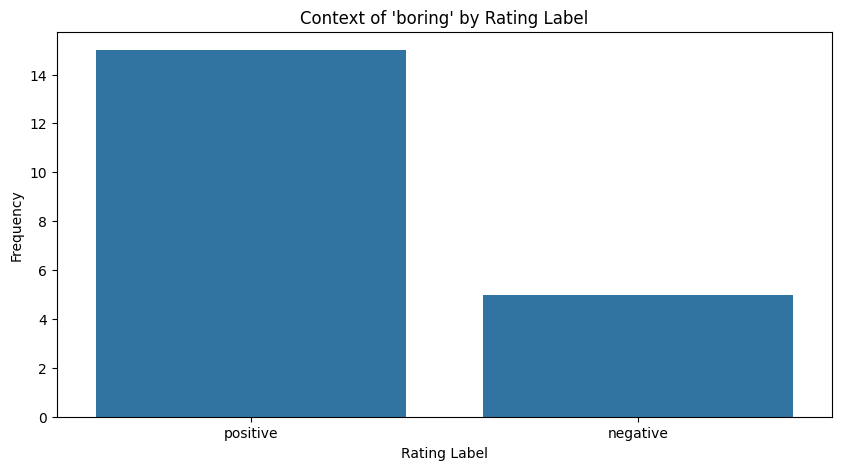

In [8]:
# Define a function to extract top keywords for each rating label
def extract_keywords_per_label(df, label_column, text_column, num_keywords=10):
    keywords = {}
    unique_labels = df[label_column].unique()
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    
    for label in unique_labels:
        label_text = df[df[label_column] == label][text_column]
        label_matrix = vectorizer.fit_transform(label_text)
        word_freq = label_matrix.sum(axis=0).A1
        vocab = vectorizer.get_feature_names_out()
        label_keywords = sorted(zip(vocab, word_freq), key=lambda x: x[1], reverse=True)[:num_keywords]
        keywords[label] = label_keywords
    
    return keywords

# Extract top keywords for positive and negative reviews
keywords = extract_keywords_per_label(df, 'rating_label', 'cleaned_snippet', num_keywords=10)
print("\nTop Keywords by Rating Label:")
for label, kw in keywords.items():
    print(f"{label.capitalize()}: {', '.join([f'{word} ({freq:.0f})' for word, freq in kw])}")

# LDA for topic modeling
def perform_topic_modeling(text_data, num_topics=5, num_words=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    doc_term_matrix = vectorizer.fit_transform(text_data)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(doc_term_matrix)
    topics = {}
    vocab = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda.components_):
        top_words = [vocab[i] for i in topic.argsort()[-num_words:]]
        topics[f"Topic {idx + 1}"] = top_words
    return topics

# Perform topic modeling for positive and negative snippets
print("\nTopic Modeling Results:")
positive_topics = perform_topic_modeling(df[df['rating_label'] == 'positive']['cleaned_snippet'])
negative_topics = perform_topic_modeling(df[df['rating_label'] == 'negative']['cleaned_snippet'])
print("\nPositive Topics:")
for topic, words in positive_topics.items():
    print(f"{topic}: {', '.join(words)}")
print("\nNegative Topics:")
for topic, words in negative_topics.items():
    print(f"{topic}: {', '.join(words)}")

# Sentiment contextualization
def contextualize_sentiment(df, keyword, label_column, text_column):
    context_data = df[df[text_column].str.contains(keyword, na=False, case=False)]
    context_count = context_data[label_column].value_counts()
    return context_count

# Example: Find context of the word 'boring'
keyword = 'boring'
context_counts = contextualize_sentiment(df, keyword, 'rating_label', 'cleaned_snippet')
print(f"\nContext of '{keyword}' in reviews:")
print(context_counts)

# Visualizing keyword context
plt.figure(figsize=(10, 5))
sns.barplot(x=context_counts.index, y=context_counts.values)
plt.title(f"Context of '{keyword}' by Rating Label")
plt.xlabel('Rating Label')
plt.ylabel('Frequency')
plt.show()